# Разработка A/B-тестирования и анализ результатов

Мы работаем продуктовым аналитиком в компании, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В нашем приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Нас, как аналитика, просят помочь рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

Мы будем работать с тремя таблицами:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
Наши задачи: рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
На первом этапе поработаем с историческими данными приложения:

- Импортируем библиотеку pandas.

- Считаем и сохраним в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

Выведем на экран первые пять строк полученного датафрейма.

In [1]:
# Импортируем библиотеки
import pandas as pd

In [2]:
## Сохраняем датафрейм
df_sessions_history = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_history.csv')

In [3]:
df_sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


In [4]:
df_sessions_history.describe()

,session_number,registration_flag,page_counter
count,435924.000000,435924.000000,435924.000000
mean,2.382908,0.077325,3.005561
std,1.288487,0.267107,1.024625
min,1.000000,0.000000,1.000000
25%,1.000000,0.000000,2.000000
50%,2.000000,0.000000,3.000000
75%,3.000000,0.000000,4.000000
max,10.000000,1.000000,7.000000


 - Средний пользователь совершает 2.38 сессии при медиане = 2
 - Максимум 10 сессий.Вероятно активные пользователи
 - Только 7.7% сессий от зарегистрированных пользователей.Большинство анонимные пользователи.

#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитаем количество уникальных сессий `session_id`.

- Выведем на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберем любого из них.

- Изучим таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.



In [5]:
# Проверим датафрейм на дубликаты
print(f'Общее кол-во строк - {len(df_sessions_history)}')
print(f"Кол-во дубликатов - {df_sessions_history['session_id'].duplicated().sum()}")

Общее кол-во строк - 435924
Кол-во дубликатов - 0


In [6]:
# Считаем кол-во уникальных сессий для каждого пользователя
user_sessions_count = df_sessions_history.groupby('user_id')['session_id'].nunique().reset_index()

Выведем на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберем любого из них

In [7]:
max_sessions = user_sessions_count['session_id'].max()
top_users = user_sessions_count[user_sessions_count['session_id'] == max_sessions]
top_users

,user_id,session_id
8948,10E0DEFC1ABDBBE0,10
55627,6A73CB5566BB494D,10


In [8]:
# Выберем все сессии одного пользователя
top_user_id = '10E0DEFC1ABDBBE0'
top_user_sessions = df_sessions_history[df_sessions_history['user_id'] == top_user_id]
top_user_sessions

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


Пользователь `10E0DEFC1ABDBBE0` был активен с 14 по 25 августа 2025 года(10 сессий за 12 дней ).Активность ежедневная кроме 21 и 23 августа. По характеристикам пользователь незарегистрирован(`registration_flag=0`) подключался с устройства Android,установил приложение 14.08.2025.Сессии преимущественно во второй половине дня.

#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируем, как менялось число регистраций в приложении за время его существования.

- Агрегируем исторические данные и рассчитаем число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты считаем, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Построим линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. Отобразим их на одном графике.

- Построим отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

- На обоих графиках должны быть заголовок, подписанные оси X и Y, сетка и легенда.

In [9]:
## Преобразуем session_date в datetime
df_sessions_history['session_date'] = pd.to_datetime(df_sessions_history['session_date'])

# Агрегируем по дням
daily_stats = df_sessions_history.groupby('session_date').agg(
    total_users=('user_id', 'nunique'),
    registered_users=('registration_flag', 'sum')
).reset_index()

# Считаем доли зарегистрированных пользователей
daily_stats['registration_ratio'] = daily_stats['registered_users'] / daily_stats['total_users']

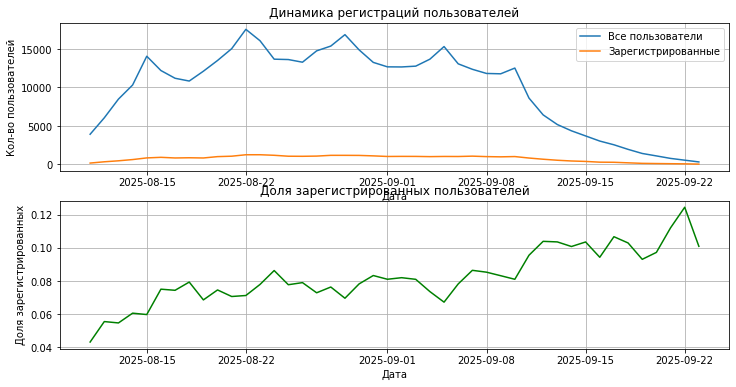

In [10]:
# Импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(12, 6))

# Строим график общего числа пользователей и зарегистрирванных
plt.subplot(2, 1, 1)
plt.plot(daily_stats['session_date'], daily_stats['total_users'], label='Все пользователи')
plt.plot(daily_stats['session_date'], daily_stats['registered_users'], label='Зарегистрированные')

# Настраиваем оформление графика
plt.title('Динамика регистраций пользователей')
plt.xlabel('Дата')
plt.ylabel('Кол-во пользователей')
plt.grid(True)
plt.legend()


# Строим график доли зарегистрированных
plt.subplot(2, 1, 2)
plt.plot(daily_stats['session_date'], daily_stats['registration_ratio'], color='green')

# Настраиваем оформление графика
plt.title('Доля зарегистрированных пользователей')
plt.xlabel('Дата')
plt.ylabel('Доля зарегистрированных')
plt.grid(True)

plt.show()

На графиках видим что пик активности приходится на 22 августа. Далее резкий спад после 10 сентября.
Максимум регистраций приходится на 23 августа а минимум регистраций на 23 сентября

#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы, что он зарегистрируется и оплатит подписку.

- Найдем количество сессий для каждого значения количества просмотренных страниц. Например: одну страницу просмотрели в 29 160 сессиях, две страницы — в 105 536 сессиях и так далее.

- Построим столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

- На диаграмме должны быть заголовок, подписанные оси X и Y.

In [11]:
# Считаем кол-во сессий для каждого значения page_counter
page_counts = df_sessions_history['page_counter'].value_counts().sort_index()
page_counts

1     29160
2    105536
3    166690
4    105569
5     26288
6      2589
7        92
Name: page_counter, dtype: int64

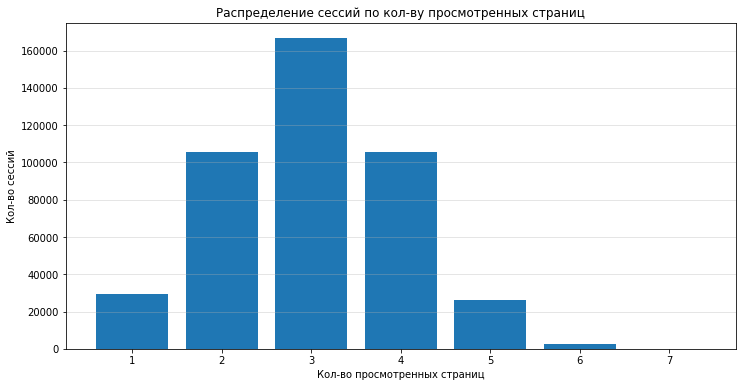

In [12]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(12, 6))

# Создаем столбчатую диаграмму
bars = plt.bar(page_counts.index, page_counts.values)

# Настраиваем оформление графика
plt.title('Распределение сессий по кол-ву просмотренных страниц')
plt.xlabel('Кол-во просмотренных страниц')
plt.ylabel('Кол-во сессий')
plt.grid(axis='y', alpha=0.4)

plt.show()

На графике наблюдаем что типичное поведение пользователей это 3 страницы. По 2 и 4 страницы распределени одинаковое

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Построим график со средним значением доли успешных сессий от всех сессий по дням за весь период наблюдения.

In [13]:
# Создаем столбец good_session
df_sessions_history['good_session'] = (df_sessions_history['page_counter'] >= 4).astype(int)

In [14]:
# Агрегируем данные успешных сессий по дням
daily_value = df_sessions_history.groupby('session_date')['good_session'].agg(
    ['mean', 'count']
).reset_index()
daily_value.columns = ['session_date', 'good_session_ratio', 'total_sessions']

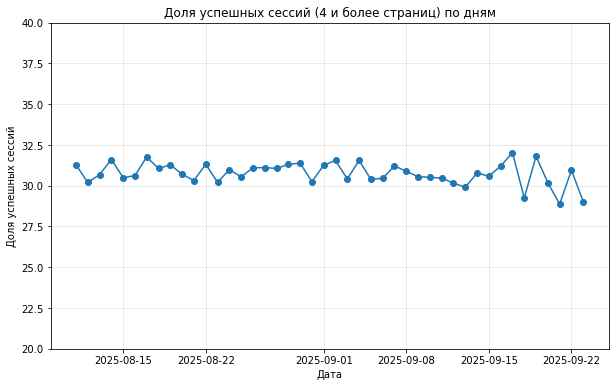

In [15]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(10, 6))

# Строим график
plt.plot(daily_value['session_date'], 
         daily_value['good_session_ratio']*100,
         marker='o',
         linestyle='-')

# Настраиваем оформление графика
plt.title('Доля успешных сессий (4 и более страниц) по дням')
plt.xlabel('Дата')
plt.ylabel('Доля успешных сессий')
plt.grid(True, alpha=0.3)
plt.ylim(20, 40) 


plt.show()

На графике видим четкую  стабильность.В период высокой активности (15-25 августа) метрика стабильна. При снижении количества сессий (в сентябре) появляются более выраженные колебания.

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Сформулировать нулевую и альтернативную гипотезы

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика рассчитать необходимую длительность проведения теста.

#### 2.2. Расчёт размера выборки

Установим в коде ниже следующие параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%. Обратите внимание, что здесь нужно указать десятичную дробь, а не процент.

При расчёте размера выборки используем метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

Запустим ячейку и изучите полученное значение.

In [16]:
from statsmodels.stats.power import NormalIndPower

# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 1-beta  # Мощность теста
mde = 0.03  # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 17441


#### 2.3. Расчёт длительности A/B-теста

Используем данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитаем длительность теста, разделив одно на другое.

- Рассчитаем среднее количество уникальных пользователей приложения в день.

- Определимдлительность теста исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. Количество дней округлим в большую сторону.

In [17]:
from math import ceil

# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = df_sessions_history.groupby('session_date')['user_id'].nunique().mean()

# Размер выборки для каждой группы
size_per_group = 17441

# Общее количество пользователей для теста (обе группы)
total_size = size_per_group * 2

# Рассчитываем длительность теста в днях
test_duration = ceil(total_size / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907.363636363636 пользователей в день составит 4 дней


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие нас метрики корректно считаются.

- Считаем и сохраните в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитаем количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитаем и выведем на экран процентную разницу в количестве пользователей в группах A и B. Построим любую удобную визуализацию, на которой будет видно возможное различие двух групп.

Для расчёта процентной разницы воспользуемся формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

In [18]:
# Сохраним датафрейм
df_sessions_test_part = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')

In [19]:
# Считаем уникальных пользователей по группам
group_counts = df_sessions_test_part.groupby('test_group')['user_id'].nunique()

In [20]:
# Извлекаем значения для групп A и B
group_a = group_counts['A']
group_b = group_counts['B']

In [21]:
# Считаем процентную разницу
percent_diff = 100 * abs(group_a - group_b) / group_a

print(f'Группа A: {group_a} пользователей')
print(f'Группа B: {group_b} пользователей')
print(f'\nПроцентная разница: {percent_diff:.2f}%')

Группа A: 1477 пользователей
Группа B: 1466 пользователей

Процентная разница: 0.74%


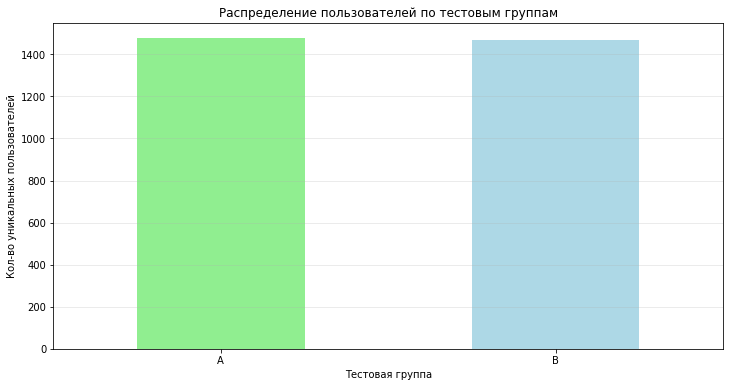

In [22]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(12, 6))

# Создаем столбчатую диаграмму
ax = group_counts.plot(kind='bar',color=['lightgreen', 'lightblue'],rot=0)

# Настраиваем оформление графика
plt.title('Распределение пользователей по тестовым группам')
plt.xlabel('Тестовая группа')
plt.ylabel('Кол-во уникальных пользователей')
plt.grid(axis='y',alpha=0.3)

plt.show()

Тест запущен корректно.Распределение пользователей между группами не имеет значимого отклонения

#### 3.2. Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах, полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

- Рассчитаем количество пользователей, которые встречаются одновременно в группах A и B, или убедимся, что таких нет.

In [23]:
# Уникальные пользователи группы A
users_a = set(df_sessions_test_part[df_sessions_test_part['test_group'] == 'A']['user_id'])

# Уникальные пользователи группы B
users_b = set(df_sessions_test_part[df_sessions_test_part['test_group'] == 'B']['user_id'])

In [24]:
# Пользователи которые есть и в группе A и в группе B
common_users = users_a & users_b
num_common_users = len(common_users)

In [25]:
if num_common_users == 0:
    print('Пересечений нет')
else:
    print(f'Найдено {num_common_users} пользователей в обеих группах:')
    print(common_users)

Пересечений нет


Все пользователи уникальны для своих групп. Пересечений между группами A и B не обнаружено.

#### 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройств и регионам.

Построим две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

Добавим на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение устройств в группах A и B.


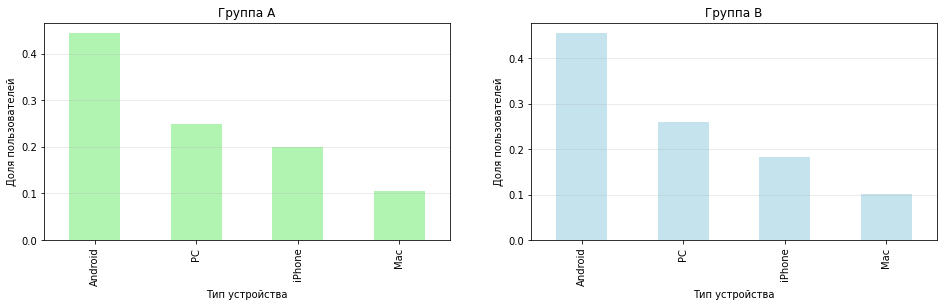

In [26]:
# Создаем подграфики
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

# Распределение устройств в группе A (по уникальным пользователям)
device_a = (df_sessions_test_part[df_sessions_test_part['test_group'] == 'A'].drop_duplicates('user_id')['device']
            .value_counts(normalize=True))
device_a.plot(kind='bar', ax=ax1, color='lightgreen', alpha=0.7)

# Настраиваем оформление графика
ax1.set_title('Группа A')
ax1.set_xlabel('Тип устройства')
ax1.set_ylabel('Доля пользователей')
ax1.grid(axis='y', alpha=0.3)

# Распределение устройств в группе B (по уникальным пользователям)
device_b = (df_sessions_test_part[df_sessions_test_part['test_group'] == 'B'].drop_duplicates('user_id')['device']
            .value_counts(normalize=True))
device_b.plot(kind='bar', ax=ax2, color='lightblue', alpha=0.7)

# Настраиваем оформление графика
ax2.set_title('Группа B')
ax2.set_xlabel('Тип устройства')
ax2.set_ylabel('Доля пользователей')
ax2.grid(axis='y', alpha=0.3)

plt.show()

Распределение устройств между тестовыми группами практически одинаково.Что подтверждает корректность проведения A/B-теста с точки зрения равномерного распределения пользователей по типам устройств.

#### 3.4. Равномерность распределения пользователей по регионам
Теперь убедимся, что пользователи равномерно распределены по регионам.

Построим две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

Добавим на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение регионов в группах A и B. 


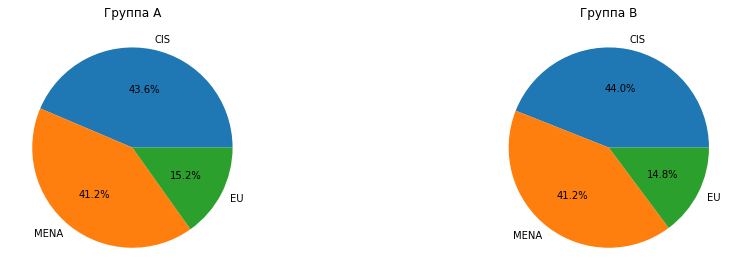

In [27]:
# Создаем подграфики
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

# Группа A (по уникальным пользователям)
region_a = (df_sessions_test_part[df_sessions_test_part['test_group'] == 'A'].drop_duplicates('user_id')['region']
            .value_counts(normalize=True))
ax1.pie(region_a, labels=region_a.index, autopct='%1.1f%%')
ax1.set_title('Группа A')

# Группа B (по уникальным пользователям)
region_b = (df_sessions_test_part[df_sessions_test_part['test_group'] == 'B'].drop_duplicates('user_id')['region']
            .value_counts(normalize=True))
ax2.pie(region_b, labels=region_b.index, autopct='%1.1f%%')
ax2.set_title('Группа B')

plt.tight_layout()
plt.show()

Доля пользователей по регионам примерно одинакова

**Вывод по результатам проверки A/B-теста**

1.Распределение количества пользователей между группами

 - Группа A — 1477 пользователей
 - Группа B — 1466 пользователей.

Количество пользователей распределено равномерно. Cтатистически значимых различий нет.

2.Независимость выборок 

 - Пересечений пользователей между группами не обнаружено.
    
Выборки независимы что соответствует корректному A/B-тесту.

3.Равномерность распределения по категориальным переменным

По устройствам:

 - Группа A: Android (43.7%), PC (25.2%), iPhone (20.4%), Mac (10.7%).

 - Группа B: Android (44.4%), PC (24.7%), iPhone (18.8%), Mac (12.1%).

Различия не значимы.

По регионам:

 - Группа A: CIS (43.7%), MENA (40.8%), EU (15.5%).

 - Группа B: MENA (46.9%), CIS (39.6%), EU (13.5%).

Есть статистически значимые различия 6% по MENA.Есть риск неверной интерпретации результатов изза регональных различий в поведении пользователей.

### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у вас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

- Считаем и сохраним в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

- В датафрейме `sessions_test` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [28]:
# Сохраним датафрейм
df_sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')

In [29]:
# Выведем основную инфрмацию по данным
df_sessions_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100005 entries, 0 to 100004
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            100005 non-null  object
 1   session_id         100005 non-null  object
 2   session_date       100005 non-null  object
 3   session_start_ts   100005 non-null  object
 4   install_date       100005 non-null  object
 5   session_number     100005 non-null  int64 
 6   registration_flag  100005 non-null  int64 
 7   page_counter       100005 non-null  int64 
 8   region             100005 non-null  object
 9   device             100005 non-null  object
 10  test_group         100005 non-null  object
dtypes: int64(3), object(8)
memory usage: 8.4+ MB


In [30]:
# Выведем временной диапазон теста
print("Начало теста", df_sessions_test['session_date'].min())
print("Конец теста", df_sessions_test['session_date'].max())

Начало теста 2025-10-14
Конец теста 2025-11-02


In [31]:
# Посомтрим статистику по `page_counter`
df_sessions_test['page_counter'].describe()

count    100005.000000
mean          3.023349
std           1.042987
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           7.000000
Name: page_counter, dtype: float64

Средний пользователь просматривает 3 страницы за сессию при медиане равной 3.Наиболее частые значения 2-4 страницы.Максимальное значение ограничено 7 страницами

In [32]:
# Создаем столбец good_session
df_sessions_test['good_session'] = (df_sessions_test['page_counter'] >= 4).astype(int)

#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и вы будете сравнивать две сопоставимые группы.

- Рассчитаем количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверим, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимыми. Используем статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

- В качестве ответа выведем на экран полученное значение p-value и интерпретируем его.

In [33]:
# Импортируем библиотеки
from scipy import stats as st

In [34]:
# Группируем по дням и тестовым группам
daily_sessions = df_sessions_test.groupby(['session_date', 'test_group'])['session_id'].nunique().unstack()

In [35]:
# Т-тест для независимых выборок
group_a = daily_sessions['A'].dropna()
group_b = daily_sessions['B'].dropna()

# Уровень статистической значимости
alpha = 0.05 

results = st.ttest_ind(
    group_a, 
    group_b)

print('p-значение:', results.pvalue)

if results.pvalue > alpha:
    print('Нет статистически значимых различий в количестве сессий между группами')
else:
    print('Обнаружены статистически значимые различия')

p-значение: 0.938219304859116
Нет статистически значимых различий в количестве сессий между группами


#### 4.3. Сравнение доли успешных сессий

Когда мы убедились, что количество сессий в обеих выборках не различалось, можно переходить к анализу ключевой метрики — доли успешных сессий.

Используем созданный на первом шаге задания столбец `good_session` и рассчитаем долю успешных сессий для выборок A и B, а также разницу в этом показателе. Полученный вывод отобразим на экране.

In [36]:
# Импортируем библиотеки
from statsmodels.stats.proportion import proportions_ztest

In [37]:
# Расчитаем доли good_session по группам
grouped = df_sessions_test.groupby('test_group')['good_session'].agg(['sum', 'count'])
m_a, n_a = grouped.loc['A', 'sum'], grouped.loc['A', 'count']
m_b, n_b = grouped.loc['B', 'sum'], grouped.loc['B', 'count']

In [38]:
# Считаем доли успешных сессий
prop_a = m_a / n_a
prop_b = m_b / n_b
diff = prop_b - prop_a
print(f'Разница долей {diff*100:.2f}%')

Разница долей 1.06%


In [39]:
# Уровень статистической значимости
alpha = 0.05

In [40]:
# Z-тест для пропорций
z_stat, p_value = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='two-sided'
)

print(f'pvalue={p_value}')

pvalue=0.0003149479976072246


In [41]:
if p_value < alpha:
    print('Различие в долях статистически значимое (p < 0.05)')
else:
    print('Различие в долях статистически не значимо (p >= 0.05)')

Различие в долях статистически значимое (p < 0.05)


#### 4.4. Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге мы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.

- Используя статистический тест, рассчитаем, является ли изменение в метрике доли успешных сессий статистически значимым.

- Выведем на экран полученное значение p-value и свои выводы о статистической значимости.

In [42]:
# Расчитаем доли good_session по группам
grouped = df_sessions_test.groupby('test_group')['good_session'].agg(['sum', 'count'])
m_a, n_a = grouped.loc['A', 'sum'], grouped.loc['A', 'count']
m_b, n_b = grouped.loc['B', 'sum'], grouped.loc['B', 'count']

In [43]:
# Считаем доли успешных сессий
prop_a = m_a / n_a
prop_b = m_b / n_b
diff = prop_b - prop_a

In [44]:
# Уровень статистической значимости
alpha = 0.05

In [45]:
# Z-тест для пропорций
z_stat, p_value = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='two-sided'
)

print(f'pvalue={p_value}')

pvalue=0.0003149479976072246


In [46]:
if p_value < alpha:
    print('Изменение статистически значимое (p < 0.05)')
    print('Новый алгоритм увеличил долю успешных сессий')
else:
    print('Изменение статистически не значимо (p >= 0.05)')
    print('Нет влияния нового алгоритма на метрику')

Изменение статистически значимое (p < 0.05)
Новый алгоритм увеличил долю успешных сессий


**Вывод по результатам A/B-эксперимента**

1. Характеристики эксперимента

 - Планируемый размер выборки 17,441 пользователей на группу (всего 34,882)

 - Расчетная длительность 4 дня (при трафике 9907 пользователей в день)

Фактический охват по первым дням теста:

 - Группа A - 1,477 пользователей

 - Группа B - 1,466 пользователей

Разница: 0.74% (распределение корректное)

2. Результаты теста

Равномерность распределения:

 - p-value = 0.938 (сессии распределены равномерно).

Доля успешных сессий (`good_session`):

 - p-value = 0.0003 (различие статистически значимо).

Вывод: Новый алгоритм увеличил долю успешных сессий.

3. Рекомендации

Внедрить новый алгоритм так как cтатистическая значимость p-value < 0.05 (вероятность ошибки < 0.03%).

Даже на малой выборке около 1500 пользователей на группу обнаружен эффект.
